# Results of CNN-BiLSTM experiments

## Setup

In [1]:
import os
import mlflow
import numpy as np
import polars as pl
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

In [2]:
fig_width = 4.78
fig_height = fig_width * 0.618

In [3]:
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "TeX Gyre Termes", "Times"],
    "font.size": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": (fig_width, fig_height),
    "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}",
})

In [4]:
mlflow.set_tracking_uri("http://localhost:5000")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [5]:
def load_predictions(
        run_id: str,
        artifact: str = "predictions/predictions.parquet"
) -> pl.DataFrame:
    aritfact_path = mlflow.artifacts.download_artifacts(
        artifact_uri=f"runs:/{run_id}/{artifact}",
    )
    df = pl.read_parquet(aritfact_path)
    os.remove(aritfact_path)
    return df

In [6]:
def get_training_metrics(run_id: str, model_name: str = "") -> None:
    client = mlflow.tracking.MlflowClient()

    loss = client.get_metric_history(run_id, "loss")
    val_loss = client.get_metric_history(run_id, "val_loss")
    acc = client.get_metric_history(run_id, "accuracy")
    val_acc = client.get_metric_history(run_id, "val_accuracy")
    restored_epoch = int(client.get_metric_history(run_id, "restored_epoch")[-1].value)

    min_len = min(
        len(loss),
        len(val_loss),
        len(acc),
        len(val_acc)
    )

    metrics_df = pd.DataFrame({
        "epoch": [m.step for m in loss[:min_len]],
        "loss": [m.value for m in loss[:min_len]],
        "val_loss": [m.value for m in val_loss[:min_len]],
        "accuracy": [m.value for m in acc[:min_len]],
        "val_accuracy": [m.value for m in val_acc[:min_len]],
    })
    metrics_df["restored_epoch"] = restored_epoch
    metrics_df.to_csv(
        f"results/{model_name.lower().replace(' ', '_').replace('-', '_')}_training.csv",
        index=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    ax1.plot(metrics_df["epoch"], metrics_df["loss"], label="Train Loss")
    ax1.plot(metrics_df["epoch"], metrics_df["val_loss"], label="Validate Loss")
    ax1.axvline(restored_epoch, color='red', linestyle='--', label=f"Restored Epoch {restored_epoch}")
    ax1.set_title("Loss per Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(metrics_df["epoch"], metrics_df["accuracy"], label="Train Accuracy")
    ax2.plot(metrics_df["epoch"], metrics_df["val_accuracy"], label="Validate Accuracy")
    ax2.axvline(restored_epoch, color='red', linestyle='--', label=f"Restored Epoch {restored_epoch}")
    ax2.set_title("Accuracy per Epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.grid(True)

    # Combine handles and labels from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    all_handles = handles1 + handles2
    all_labels = labels1 + labels2

    # Remove duplicates while preserving order
    from collections import OrderedDict
    unique = list(OrderedDict(zip(all_labels, all_handles)).items())
    fig.legend(
        [h for _, h in unique], [l for l, _ in unique],
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=3
    )

    if model_name:
        plt.suptitle(f"Training Metrics for {model_name} model")

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # make room for legend

    plt.show()

In [7]:
def classification_report(df: pl.DataFrame, label: str = 'Label') -> pd.DataFrame:
    # First, calculate TP, FN, FP, TN
    df = df.with_columns(
        (pl.col("y") & pl.col("y_pred")).alias("TP"),
        (pl.col("y") & ~pl.col("y_pred")).alias("FN"),
        (~pl.col("y") & pl.col("y_pred")).alias("FP"),
        (~pl.col("y") & ~pl.col("y_pred")).alias("TN"),
    )

    # Aggregate the confusion matrix values by the label
    df = df.select([label, "TP", "FN", "FP", "TN"]
    ).group_by(label
    ).agg([
        pl.sum("TP").alias("TP"),
        pl.sum("FN").alias("FN"),
        pl.sum("FP").alias("FP"),
        pl.sum("TN").alias("TN"),
    ])

    df = df.with_columns(
        # Recall
        (pl.col("TP") / (pl.col("TP") + pl.col("FN"))).alias("Recall"),
        # Precision
        (pl.col("TP") / (pl.col("TP") + pl.col("FP"))).alias("Precision"),
        # Accuracy
        ((pl.col("TP") + pl.col("TN")) / (pl.col("TP") + pl.col("TN") + pl.col("FP") + pl.col("FN"))).alias(
            "Accuracy"
        ),
    )

    df = df.with_columns(
        # F1 Score
        (2 * (pl.col("Precision") * pl.col("Recall")) / (pl.col("Precision") + pl.col("Recall"))).alias("F1 Score"),
        # Specificity
        (pl.col("TN") / (pl.col("TN") + pl.col("FP"))).alias("Specificity"),
        # False Positive Rate
        (pl.col("FP") / (pl.col("FP") + pl.col("TN"))).alias("FPR"),
        # False Negative Rate
        (pl.col("FN") / (pl.col("FN") + pl.col("TP"))).alias("FNR"),
    )

    pdf = df.to_pandas().set_index(label).sort_index()

    overall = {
        "TP": pdf["TP"].sum(),
        "FN": pdf["FN"].sum(),
        "FP": pdf["FP"].sum(),
        "TN": pdf["TN"].sum(),
    }
    overall["Recall"] = overall["TP"] / (overall["TP"] + overall["FN"])
    overall["Precision"] = overall["TP"] / (overall["TP"] + overall["FP"])
    overall["Accuracy"] = (overall["TP"] + overall["TN"]) / (
        overall["TP"] + overall["TN"] + overall["FP"] + overall["FN"]
    )
    overall["F1 Score"] = 2 * (overall["Precision"] * overall["Recall"]) / (
        overall["Precision"] + overall["Recall"]
    )
    overall["Specificity"] = overall["TN"] / (overall["TN"] + overall["FP"])
    overall["FPR"] = overall["FP"] / (overall["FP"] + overall["TN"])
    overall["FNR"] = overall["FN"] / (overall["FN"] + overall["TP"])

    pdf.loc["Overall"] = overall

    return pdf

In [8]:
def plot_confusion_matrices(reports: list, labels: list, title: str = "", export_path: str = "") -> None:
    n = len(reports)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
    if n == 1:
        axes = [axes]

    for i, (report, label) in enumerate(zip(reports, labels)):
        # Sum values for overall confusion matrix
        cm = np.array([
            [report['TP'].sum(), report['FP'].sum()],
            [report['FN'].sum(), report['TN'].sum()]
        ])

        # Plot heatmap
        sns.heatmap(
            cm,
            annot=True,
            fmt=',d',
            cmap='Blues',
            xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'],
            ax=axes[i]
        )
        axes[i].set_title(f"{label}")
        axes[i].set_ylabel('True')
        axes[i].set_xlabel('Predicted')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    if export_path:
        plt.savefig(export_path,
                    format="pdf",
                    bbox_inches="tight",
                    pad_inches=0.1)

    plt.show()

In [9]:
def plot_roc_curves(datasets: list, labels: list, title: str = '', export_path: str = '') -> None:
    plt.figure(figsize=(10, 8))
    colors = sns.color_palette("viridis", len(datasets))

    for i, (df, label) in enumerate(zip(datasets, labels)):
        # Get ground truth and predicted probabilities
        y_true = df['y'].to_numpy()
        y_score = df['y_pred_proba'].to_numpy()

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        # Plot curve
        plt.plot(
            fpr, tpr,
            lw=2,
            color=colors[i],
            label=f'{label} (AUC = {roc_auc:.4f})'
        )

    # Add reference line and formatting
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if title:
        plt.title(title)
    plt.legend(loc="lower right")

    if export_path:
        plt.savefig(export_path,
                    format="pdf",
                    bbox_inches="tight",
                    pad_inches=0.1)

    plt.show()

## Load results

In [10]:
cic_ids_2017_id = "9b0c83b43e6d4a5fbbce60e1c0823db8"
cic_ids_2017_pred = load_predictions(cic_ids_2017_id)
cic_ids_2017_pred.select(pl.col(["Label", "y", "y_pred", "y_pred_proba"])).head()

Label,y,y_pred,y_pred_proba
str,bool,bool,f32
"""BENIGN""",false,false,0.000013
"""BENIGN""",false,false,0.000002
"""BENIGN""",false,false,0.000012
"""DoS Hulk""",true,true,0.999989
"""BENIGN""",false,false,0.000036


In [11]:
mawi_2011_01_id = "201980eb873f467cb59ea8371b3f1753"
mawi_2011_01_pred = load_predictions(mawi_2011_01_id).with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""suspicious""","""mptpHTTP""",true,true,0.717695
"""anomalous""","""mptmp""",true,true,0.974391
"""benign""","""benign""",false,false,0.299357
"""anomalous""","""mptpHTTP""",true,true,0.993257
"""benign""","""benign""",false,false,0.196856


In [12]:
mawi_2016_01_id = "944db0f555b64b33b84c8016788207d5"
mawi_2016_01_pred = load_predictions(mawi_2016_01_id).with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2016_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""anomalous""","""mptpHTTP""",true,true,0.993751
"""benign""","""benign""",false,true,0.558104
"""anomalous""","""mptp""",true,true,0.950984
"""benign""","""benign""",false,false,0.238849
"""anomalous""","""mptmp""",true,false,0.239303


In [13]:
mawi_2021_01_id = "2e0c08f7a1944b309cd94eb8669ebb33"
mawi_2021_01_pred = load_predictions(mawi_2021_01_id).with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2021_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""benign""","""benign""",false,true,0.6162
"""anomalous""","""mptmp""",true,true,0.984735
"""anomalous""","""mptmp""",true,true,0.982213
"""anomalous""","""mptmp""",true,true,0.954193
"""anomalous""","""mptmp""",true,true,0.9421


In [14]:
cic_ids_2017_on_mawi_2011_01_pred = load_predictions("a4e23d21dfbf4cae8465ca84d7f0ec20").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
cic_ids_2017_on_mawi_2011_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""benign""","""benign""",false,true,0.698997
"""suspicious""","""mptmp""",true,true,0.848526
"""anomalous""","""mptmp""",true,true,0.869376
"""notice""","""mptpHTTP""",true,false,0.002537
"""anomalous""","""mptpHTTP""",true,false,0.000009


In [15]:
cic_ids_2017_on_mawi_2021_01_pred = load_predictions("97a1af0497714bfbbc05a4126f6f0757").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
cic_ids_2017_on_mawi_2021_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""anomalous""","""mptmp""",true,false,0.000002
"""anomalous""","""mptmp""",true,false,0.000001
"""anomalous""","""mptmp""",true,false,0.000004
"""anomalous""","""mptmp""",true,false,0.187656
"""anomalous""","""mptmp""",true,false,0.000006


In [16]:
mawi_2011_01_on_cic_ids_2017_pred = load_predictions("90c8b7fa29ab4d67b2dd56029c473bcb")
mawi_2011_01_on_cic_ids_2017_pred.select(pl.col(["Label", "y", "y_pred", "y_pred_proba"])).head()

Label,y,y_pred,y_pred_proba
str,bool,bool,f32
"""BENIGN""",false,true,0.831068
"""BENIGN""",false,false,0.362503
"""BENIGN""",false,true,0.768349
"""BENIGN""",false,false,0.295221
"""BENIGN""",false,true,0.769068


In [17]:
mawi_2011_01_on_mawi_2016_01_pred = load_predictions("e223052a451e49d4998e74287a7b9b74").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_on_mawi_2016_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""benign""","""benign""",false,false,0.44592
"""anomalous""","""mptmp""",true,true,0.643537
"""benign""","""benign""",false,true,0.968423
"""anomalous""","""mptmp""",true,true,0.906966
"""benign""","""benign""",false,false,0.377699


In [18]:
mawi_2011_01_on_mawi_2021_01_pred = load_predictions("781f52f81dc5481a967da5fcb60b46fa").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_on_mawi_2021_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""anomalous""","""mptmp""",true,true,0.627528
"""anomalous""","""mptmp""",true,true,0.646739
"""anomalous""","""mptmp""",true,true,0.897081
"""anomalous""","""mptmp""",true,false,0.102182
"""anomalous""","""mptmp""",true,true,0.905804


In [19]:
mawi_2021_01_on_cic_ids_2017_pred = load_predictions("bfb5966e147547a4a6e0fbf1d8df6e62")
mawi_2021_01_on_cic_ids_2017_pred.select(pl.col(["Label", "y", "y_pred", "y_pred_proba"])).head()

Label,y,y_pred,y_pred_proba
str,bool,bool,f32
"""BENIGN""",false,false,0.192647
"""BENIGN""",false,false,0.257887
"""BENIGN""",false,false,0.323166
"""BENIGN""",false,true,0.646758
"""BENIGN""",false,false,0.192647


In [20]:
mawi_2021_01_on_mawi_2011_01_pred = load_predictions("13937c99fac24a8ab98b17504f5b224e").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2021_01_on_mawi_2011_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""benign""","""benign""",false,true,0.890848
"""suspicious""","""mptmp""",true,true,0.889606
"""anomalous""","""mptmp""",true,true,0.903971
"""notice""","""mptpHTTP""",true,true,0.915704
"""anomalous""","""mptpHTTP""",true,true,0.928276


In [21]:
mawi_2021_01_on_mawi_2016_01_pred = load_predictions("2c2c770eb086497393b5dd8f5bf11232").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2021_01_on_mawi_2016_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""benign""","""benign""",false,false,0.367242
"""anomalous""","""mptmp""",true,false,0.325884
"""benign""","""benign""",false,true,0.980348
"""anomalous""","""mptmp""",true,true,0.944201
"""benign""","""benign""",false,false,0.381108


In [22]:
mawi_2016_01_on_mawi_2011_01_pred = load_predictions("e3f765ddbc09421aa9964b4f060a549b").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2016_01_on_mawi_2011_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""benign""","""benign""",false,true,0.993698
"""suspicious""","""mptmp""",true,true,0.994531
"""anomalous""","""mptmp""",true,true,0.994886
"""notice""","""mptpHTTP""",true,true,0.934229
"""anomalous""","""mptpHTTP""",true,true,0.991431


In [23]:
mawi_2016_01_on_mawi_2021_01_pred = load_predictions("b4b7b950b75c40a294b0136fae21b9e7").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2016_01_on_mawi_2021_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""anomalous""","""mptmp""",true,true,0.912446
"""anomalous""","""mptmp""",true,false,0.486689
"""anomalous""","""mptmp""",true,true,0.589327
"""anomalous""","""mptmp""",true,true,0.747548
"""anomalous""","""mptmp""",true,true,0.615708


In [24]:
mawi_2011_01_2016_01_id = "48728c436c7341fa9785f71a4a78fdef"
mawi_2011_01_2016_01_pred = load_predictions(mawi_2011_01_2016_01_id).with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_2016_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""anomalous""","""ptmp""",true,false,0.494317
"""benign""","""benign""",false,false,0.232308
"""suspicious""","""mptmp""",true,true,0.847696
"""benign""","""benign""",false,false,0.232845
"""anomalous""","""ntscSYNt""",true,true,0.897798


In [25]:
mawi_2011_01_2016_01_on_mawi_2016_01_pred = load_predictions("68a5593ecaac4676818985691d0129c2").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_2016_01_on_mawi_2016_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""benign""","""benign""",false,false,0.232591
"""anomalous""","""mptmp""",true,false,0.232267
"""benign""","""benign""",false,true,0.803195
"""anomalous""","""mptmp""",true,true,0.892747
"""benign""","""benign""",false,false,0.232768


In [26]:
mawi_2011_01_2016_01_on_mawi_2021_01_pred = load_predictions("eb1cf975a4204d2e8bbfa3ce41fe76fe").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_2016_01_on_mawi_2021_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""anomalous""","""mptmp""",true,true,0.682127
"""anomalous""","""mptmp""",true,true,0.640356
"""anomalous""","""mptmp""",true,true,0.709222
"""anomalous""","""mptmp""",true,false,0.030755
"""anomalous""","""mptmp""",true,true,0.794193


In [27]:
mawi_2011_01_2021_01_id = "73e9f6589ea8430cbebfa98c04c37956"
mawi_2011_01_2021_01_pred = load_predictions(mawi_2011_01_2021_01_id).with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_2021_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""benign""","""benign""",false,true,0.854158
"""anomalous""","""mptmp""",true,true,0.981584
"""benign""","""benign""",false,true,0.606744
"""suspicious""","""mptpHTTP""",true,true,0.98827
"""anomalous""","""ipv46tun""",true,true,0.976306


In [28]:
mawi_2011_01_2021_01_on_mawi_2016_01_pred = load_predictions("cfce0401f7404a1688b31ecf06c9c4df").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_2021_01_on_mawi_2016_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""benign""","""benign""",false,false,0.377383
"""anomalous""","""mptmp""",true,false,0.435465
"""benign""","""benign""",false,true,0.99306
"""anomalous""","""mptmp""",true,true,0.886609
"""benign""","""benign""",false,false,0.371276


In [29]:
mawi_2011_01_2021_01_on_mawi_2021_01_pred = load_predictions("c1935f1fa9084d8cb39023849530bd5f").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_2021_01_on_mawi_2021_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""anomalous""","""mptmp""",true,true,0.913927
"""anomalous""","""mptmp""",true,true,0.997166
"""anomalous""","""mptmp""",true,true,0.99788
"""anomalous""","""mptmp""",true,true,0.948264
"""anomalous""","""mptmp""",true,true,0.99814


In [30]:
mawi_2011_01_2016_01_2021_01_id = "a7502ab25dc14e708c8a2d36905acfbc"
mawi_2011_01_2016_01_2021_01_pred = load_predictions(mawi_2011_01_2016_01_2021_01_id).with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_2016_01_2021_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""suspicious""","""ipv46tun""",true,false,0.251176
"""anomalous""","""mptmp""",true,true,0.942348
"""suspicious""","""ntscUDP""",true,true,0.969796
"""benign""","""benign""",false,false,0.231683
"""benign""","""benign""",false,false,0.468464


In [31]:
mawi_2011_01_2016_01_2021_01_on_mawi_2016_01_pred = load_predictions("cd1e036fe6ed446c92bd3692af42a7ed").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_2016_01_2021_01_on_mawi_2016_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""benign""","""benign""",false,false,0.231531
"""anomalous""","""mptmp""",true,false,0.23125
"""benign""","""benign""",false,true,0.957159
"""anomalous""","""mptmp""",true,true,0.916925
"""benign""","""benign""",false,false,0.231675


In [32]:
mawi_2011_01_2016_01_2021_01_on_mawi_2021_01_pred = load_predictions("d2a24bd6239b49dcb6c5f8224e242bfa").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_2016_01_2021_01_on_mawi_2021_01_pred.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f32
"""anomalous""","""mptmp""",true,true,0.867287
"""anomalous""","""mptmp""",true,true,0.998657
"""anomalous""","""mptmp""",true,true,0.998756
"""anomalous""","""mptmp""",true,true,0.949089
"""anomalous""","""mptmp""",true,true,0.998895


In [33]:
mawi_2011_01_pred_rf = load_predictions("d2c8eb407e3442cc86c0c3ad75d76a15").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_pred_rf.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f64
"""suspicious""","""mptpHTTP""",true,true,0.84
"""anomalous""","""mptmp""",true,true,0.97
"""benign""","""benign""",false,false,0.013333
"""anomalous""","""mptpHTTP""",true,true,1.0
"""benign""","""benign""",false,true,0.746548


In [34]:
mawi_2011_01_on_mawi_2016_01_pred_rf = load_predictions("0239db8d37504520b48f80bb219d27ca").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_on_mawi_2016_01_pred_rf.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,bool
"""benign""","""benign""",false,false,false
"""anomalous""","""mptmp""",true,false,false
"""benign""","""benign""",false,true,true
"""anomalous""","""mptmp""",true,true,true
"""benign""","""benign""",false,false,false


In [35]:
mawi_2011_01_on_mawi_2021_01_pred_rf = load_predictions("20e0ad63f0fe47efa75d66419571a4c3").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2011_01_on_mawi_2021_01_pred_rf.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,bool
"""anomalous""","""mptmp""",true,true,true
"""anomalous""","""mptmp""",true,false,false
"""anomalous""","""mptmp""",true,true,true
"""anomalous""","""mptmp""",true,false,false
"""anomalous""","""mptmp""",true,false,false


In [36]:
mawi_2016_01_pred_rf = load_predictions("dea1571112a249759febd7dfebbe3db0").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2016_01_pred_rf.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f64
"""anomalous""","""mptpHTTP""",true,true,1.0
"""benign""","""benign""",false,true,0.53
"""anomalous""","""mptp""",true,true,0.99
"""benign""","""benign""",false,false,0.0
"""anomalous""","""mptmp""",true,true,0.501


In [37]:
mawi_2016_01_on_mawi_2011_01_pred_rf = load_predictions("457cc9494b6c42aaa079e50888be08d3").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2016_01_on_mawi_2011_01_pred_rf.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,bool
"""benign""","""benign""",false,true,true
"""suspicious""","""mptmp""",true,true,true
"""anomalous""","""mptmp""",true,true,true
"""notice""","""mptpHTTP""",true,true,true
"""anomalous""","""mptpHTTP""",true,true,true


In [38]:
mawi_2016_01_on_mawi_2021_01_pred_rf = load_predictions("1de6481fdb2c40609027c6f601a5a561").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2016_01_on_mawi_2021_01_pred_rf.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,bool
"""anomalous""","""mptmp""",true,true,true
"""anomalous""","""mptmp""",true,false,false
"""anomalous""","""mptmp""",true,false,false
"""anomalous""","""mptmp""",true,true,true
"""anomalous""","""mptmp""",true,false,false


In [39]:
mawi_2021_01_pred_rf = load_predictions("49856877a42e49848a5d0a6177da09f6").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2021_01_pred_rf.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,f64
"""benign""","""benign""",false,true,0.81
"""anomalous""","""mptmp""",true,true,1.0
"""anomalous""","""mptmp""",true,true,1.0
"""anomalous""","""mptmp""",true,true,0.92
"""anomalous""","""mptmp""",true,true,1.0


In [40]:
mawi_2021_01_on_mawi_2011_01_pred_rf = load_predictions("99b955edccb54b46a210058580df952e").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2021_01_on_mawi_2011_01_pred_rf.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,bool
"""benign""","""benign""",false,true,true
"""suspicious""","""mptmp""",true,true,true
"""anomalous""","""mptmp""",true,true,true
"""notice""","""mptpHTTP""",true,true,true
"""anomalous""","""mptpHTTP""",true,true,true


In [41]:
mawi_2021_01_on_mawi_2016_01_pred_rf = load_predictions("2b0da2e9982d40d3a72da723032f12bc").with_columns(
    pl.when(pl.col("Taxonomy").is_null()).then(pl.lit("benign")).otherwise(pl.col("Taxonomy")).alias("Taxonomy")
)
mawi_2021_01_on_mawi_2016_01_pred_rf.select(pl.col(["Label", "Taxonomy", "y", "y_pred", "y_pred_proba"])).head()

Label,Taxonomy,y,y_pred,y_pred_proba
str,str,bool,bool,bool
"""benign""","""benign""",false,false,false
"""anomalous""","""mptmp""",true,false,false
"""benign""","""benign""",false,true,true
"""anomalous""","""mptmp""",true,true,true
"""benign""","""benign""",false,false,false


## CNN-BiLSTM model training

### CIC-IDS-2017

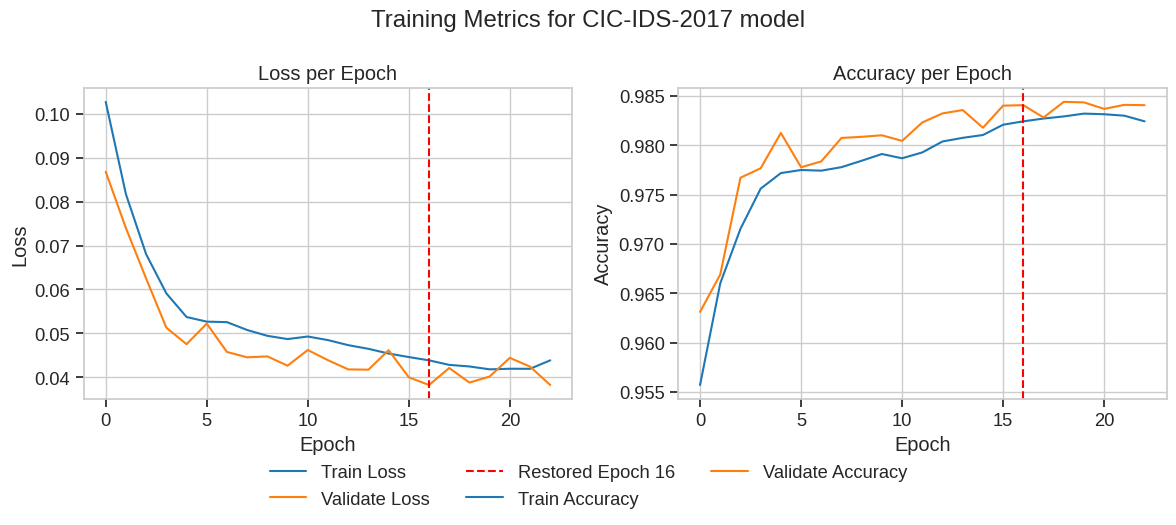

In [42]:
get_training_metrics(cic_ids_2017_id, "CIC-IDS-2017")

### MAWILab-2011-01

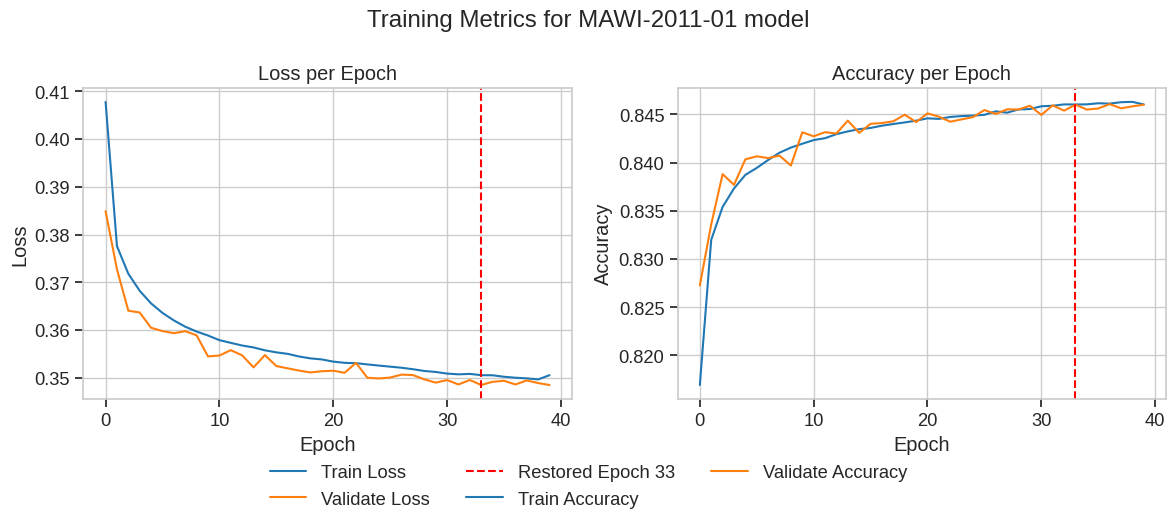

In [43]:
get_training_metrics(mawi_2011_01_id, "MAWI-2011-01")

### MAWILab-2016-01

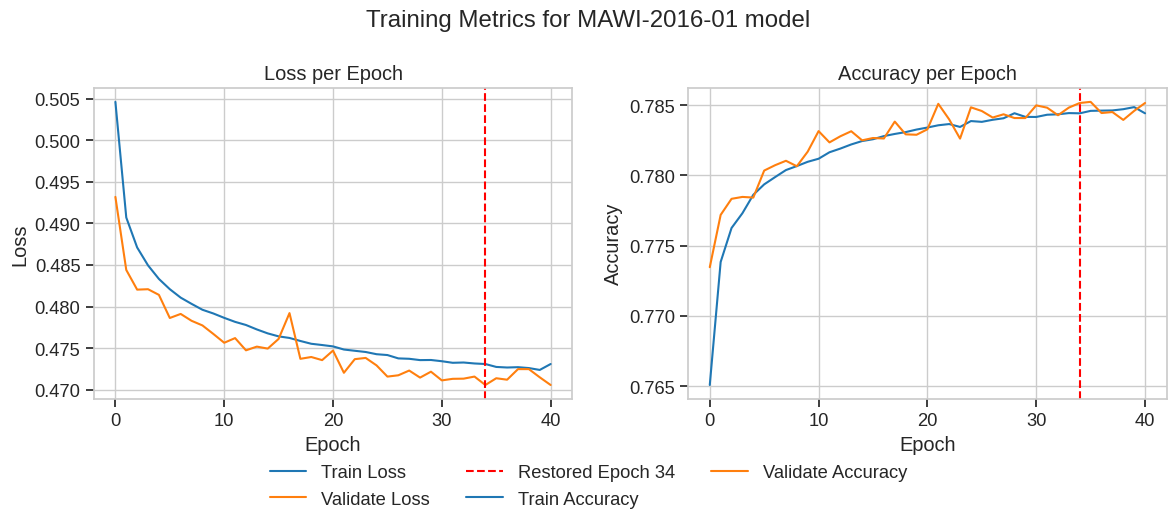

In [44]:
get_training_metrics(mawi_2016_01_id, "MAWI-2016-01")

### MAWILab-2021-02

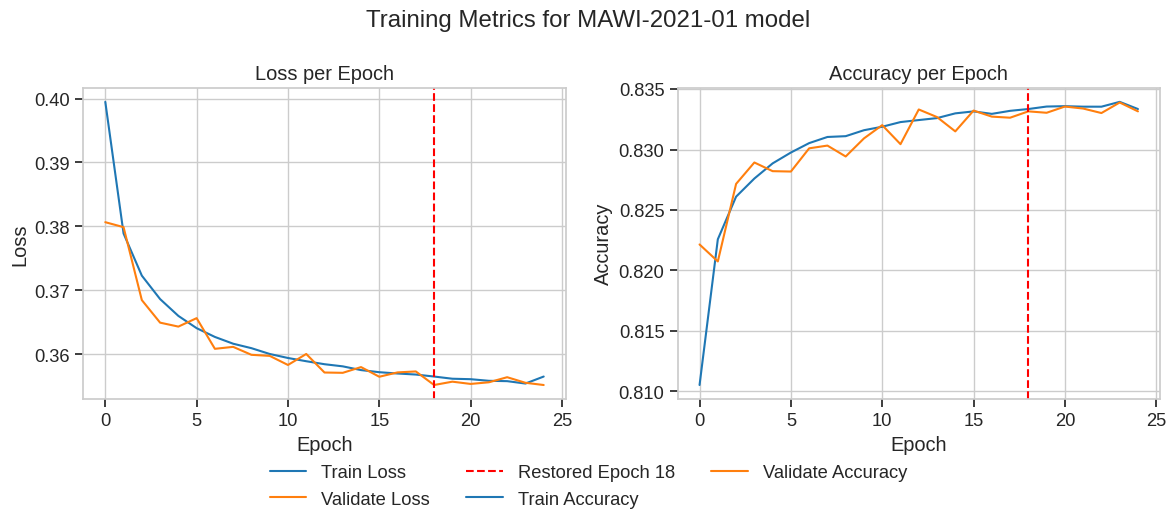

In [45]:
get_training_metrics(mawi_2021_01_id, "MAWI-2021-01")

## Evaluation

In [46]:
cic_ids_2017_report = classification_report(cic_ids_2017_pred)
cic_ids_2017_report.to_csv("results/cic_ids_2017_report.csv")

mawi_2011_01_report_labels = classification_report(mawi_2011_01_pred)
mawi_2011_01_report_labels.to_csv("results/mawi_2011_01_report_labels.csv")

mawi_2011_01_report_taxonomies = classification_report(mawi_2011_01_pred, label="Taxonomy")
mawi_2011_01_report_taxonomies.to_csv("results/mawi_2011_01_report_taxonomies.csv")

mawi_2016_01_report_labels = classification_report(mawi_2016_01_pred)
mawi_2016_01_report_labels.to_csv("results/mawi_2016_01_report_labels.csv")

mawi_2016_01_report_taxonomies = classification_report(mawi_2016_01_pred, label="Taxonomy")
mawi_2016_01_report_taxonomies.to_csv("results/mawi_2016_01_report_taxonomies.csv")

mawi_2021_01_report_labels = classification_report(mawi_2021_01_pred)
mawi_2021_01_report_labels.to_csv("results/mawi_2021_01_report_labels.csv")

mawi_2021_01_report_taxonomies = classification_report(mawi_2021_01_pred, label="Taxonomy")
mawi_2021_01_report_taxonomies.to_csv("results/mawi_2021_01_report_taxonomies.csv")

mawi_2011_01_2016_01_report_labels = classification_report(mawi_2011_01_2016_01_pred)
mawi_2011_01_2016_01_report_labels.to_csv("results/mawi_2011_01_2016_01_report_labels.csv")

mawi_2011_01_2016_01_report_taxonomies = classification_report(mawi_2011_01_2016_01_pred, label="Taxonomy")
mawi_2011_01_2016_01_report_taxonomies.to_csv("results/mawi_2011_01_2016_01_report_taxonomies.csv")

mawi_2011_01_2021_01_report_labels = classification_report(mawi_2011_01_2021_01_pred)
mawi_2011_01_2021_01_report_labels.to_csv("results/mawi_2011_01_2021_01_report_labels.csv")

mawi_2011_01_2021_01_report_taxonomies = classification_report(mawi_2011_01_2021_01_pred, label="Taxonomy")
mawi_2011_01_2021_01_report_taxonomies.to_csv("results/mawi_2011_01_2021_01_report_taxonomies.csv")

mawi_2011_01_2016_01_2021_01_report_labels = classification_report(mawi_2011_01_2016_01_2021_01_pred)
mawi_2011_01_2016_01_2021_01_report_labels.to_csv("results/mawi_2011_01_2016_01_2021_01_report_labels.csv")

mawi_2011_01_2016_01_2021_01_report_taxonomies = classification_report(
    mawi_2011_01_2016_01_2021_01_pred, label="Taxonomy"
)
mawi_2011_01_2016_01_2021_01_report_taxonomies.to_csv("results/mawi_2011_01_2016_01_2021_01_report_taxonomies.csv")

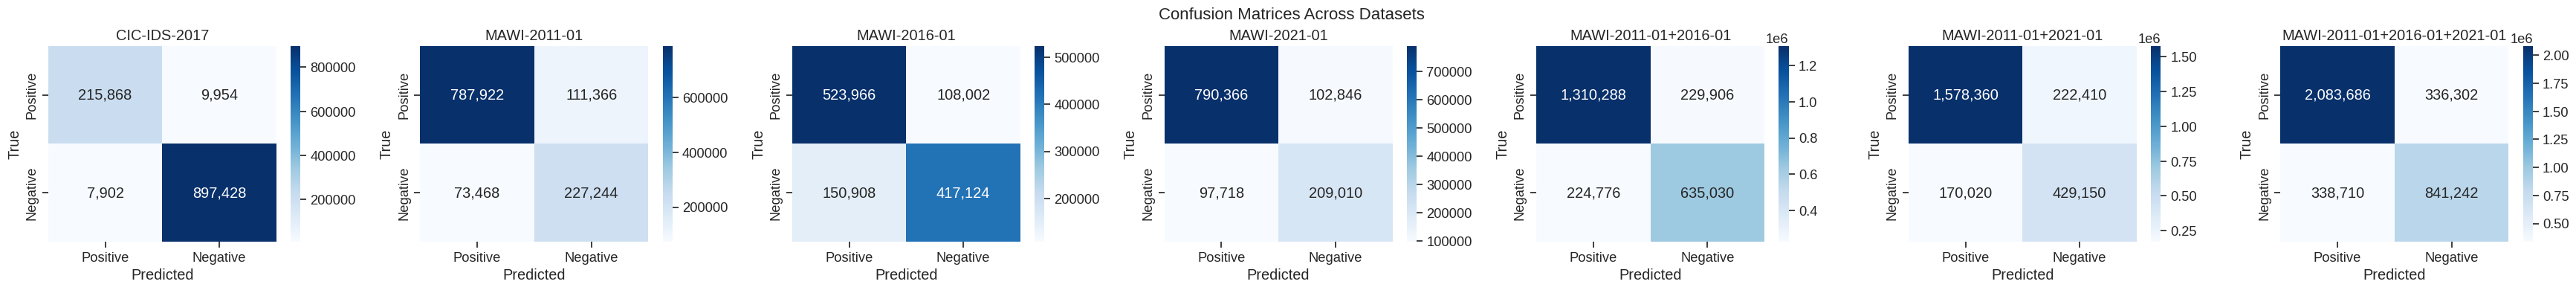

In [47]:
plot_confusion_matrices(
    [
        cic_ids_2017_report,
        mawi_2011_01_report_labels,
        mawi_2016_01_report_labels,
        mawi_2021_01_report_labels,
        mawi_2011_01_2016_01_report_labels,
        mawi_2011_01_2021_01_report_labels,
        mawi_2011_01_2016_01_2021_01_report_labels
    ],
    [
        "CIC-IDS-2017",
        "MAWI-2011-01",
        "MAWI-2016-01",
        "MAWI-2021-01",
        "MAWI-2011-01+2016-01",
        "MAWI-2011-01+2021-01",
        "MAWI-2011-01+2016-01+2021-01"
    ],
    "Confusion Matrices Across Datasets",
    export_path="results/confusion_matrices_test_subset.pdf"
)

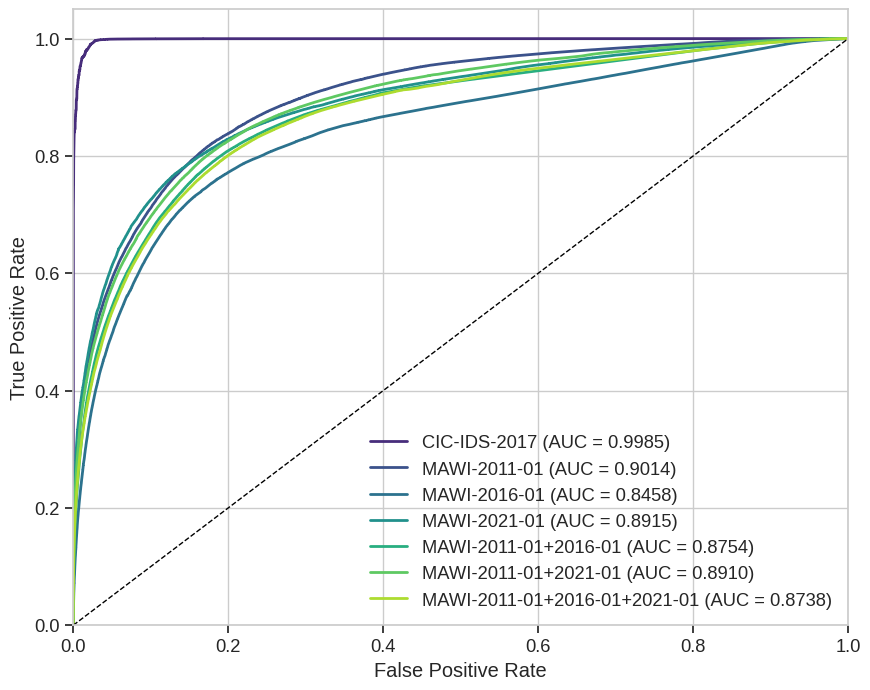

In [48]:
plot_roc_curves(
    [
        cic_ids_2017_pred,
        mawi_2011_01_pred,
        mawi_2016_01_pred,
        mawi_2021_01_pred,
        mawi_2011_01_2016_01_pred,
        mawi_2011_01_2021_01_pred,
        mawi_2011_01_2016_01_2021_01_pred,
    ],
    [
        "CIC-IDS-2017",
        "MAWI-2011-01",
        "MAWI-2016-01",
        "MAWI-2021-01",
        "MAWI-2011-01+2016-01",
        "MAWI-2011-01+2021-01",
        "MAWI-2011-01+2016-01+2021-01"
    ],
    export_path="results/roc_curves_test_subset.pdf"
)

## Cross-dataset evaluation

In [49]:
cic_ids_2017_on_mawi_2011_01_report_labels = classification_report(cic_ids_2017_on_mawi_2011_01_pred)
cic_ids_2017_on_mawi_2011_01_report_labels.to_csv("results/cic_ids_2017_on_mawi_2011_01_report_labels.csv")
cic_ids_2017_on_mawi_2011_01_report_taxonomies = classification_report(cic_ids_2017_on_mawi_2011_01_pred, label="Taxonomy")
cic_ids_2017_on_mawi_2011_01_report_taxonomies.to_csv("results/cic_ids_2017_on_mawi_2011_01_report_taxonomies.csv")

cic_ids_2017_on_mawi_2021_01_report_labels = classification_report(cic_ids_2017_on_mawi_2021_01_pred)
cic_ids_2017_on_mawi_2021_01_report_labels.to_csv("results/cic_ids_2017_on_mawi_2021_01_report_labels.csv")
cic_ids_2017_on_mawi_2021_01_report_taxonomies = classification_report(cic_ids_2017_on_mawi_2021_01_pred, label="Taxonomy")
cic_ids_2017_on_mawi_2021_01_report_taxonomies.to_csv("results/cic_ids_2017_on_mawi_2021_01_report_taxonomies.csv")

In [50]:
mawi_2011_01_on_cic_ids_2017_report = classification_report(mawi_2011_01_on_cic_ids_2017_pred)
mawi_2011_01_on_cic_ids_2017_report.to_csv("results/mawi_2011_01_on_cic_ids_2017_report.csv")

mawi_2011_01_on_mawi_2016_01_report_labels = classification_report(mawi_2011_01_on_mawi_2016_01_pred)
mawi_2011_01_on_mawi_2016_01_report_labels.to_csv("results/mawi_2011_01_on_mawi_2016_01_report_labels.csv")
mawi_2011_01_on_mawi_2016_01_report_taxonomies = classification_report(mawi_2011_01_on_mawi_2016_01_pred, label="Taxonomy")
mawi_2011_01_on_mawi_2016_01_report_taxonomies.to_csv("results/mawi_2011_01_on_mawi_2016_01_report_taxonomies.csv")

mawi_2011_01_on_mawi_2021_01_report_labels = classification_report(mawi_2011_01_on_mawi_2021_01_pred)
mawi_2011_01_on_mawi_2021_01_report_labels.to_csv("results/mawi_2011_01_on_mawi_2021_01_report_labels.csv")
mawi_2011_01_on_mawi_2021_01_report_taxonomies = classification_report(mawi_2011_01_on_mawi_2021_01_pred, label="Taxonomy")
mawi_2011_01_on_mawi_2021_01_report_taxonomies.to_csv("results/mawi_2011_01_on_mawi_2021_01_report_taxonomies.csv")

In [51]:
mawi_2016_01_on_mawi_2011_01_report_labels = classification_report(mawi_2016_01_on_mawi_2011_01_pred)
mawi_2016_01_on_mawi_2011_01_report_labels.to_csv("results/mawi_2016_01_on_mawi_2011_01_report_labels.csv")
mawi_2016_01_on_mawi_2011_01_report_taxonomies = classification_report(mawi_2016_01_on_mawi_2011_01_pred, label="Taxonomy")
mawi_2016_01_on_mawi_2011_01_report_taxonomies.to_csv("results/mawi_2016_01_on_mawi_2011_01_report_taxonomies.csv")

mawi_2016_01_on_mawi_2021_01_report_labels = classification_report(mawi_2016_01_on_mawi_2021_01_pred)
mawi_2016_01_on_mawi_2021_01_report_labels.to_csv("results/mawi_2016_01_on_mawi_2021_01_report_labels.csv")
mawi_2016_01_on_mawi_2021_01_report_taxonomies = classification_report(mawi_2016_01_on_mawi_2021_01_pred, label="Taxonomy")
mawi_2016_01_on_mawi_2021_01_report_taxonomies.to_csv("results/mawi_2016_01_on_mawi_2021_01_report_taxonomies.csv")

In [52]:
mawi_2021_01_on_cic_ids_2017_report = classification_report(mawi_2021_01_on_cic_ids_2017_pred)
mawi_2021_01_on_cic_ids_2017_report.to_csv("results/mawi_2021_01_on_cic_ids_2017_report.csv")

mawi_2021_01_on_mawi_2011_01_report_labels = classification_report(mawi_2021_01_on_mawi_2011_01_pred)
mawi_2021_01_on_mawi_2011_01_report_labels.to_csv("results/mawi_2021_01_on_mawi_2011_01_report_labels.csv")
mawi_2021_01_on_mawi_2011_01_report_taxonomies = classification_report(mawi_2021_01_on_mawi_2011_01_pred, label="Taxonomy")
mawi_2021_01_on_mawi_2011_01_report_taxonomies.to_csv("results/mawi_2021_01_on_mawi_2011_01_report_taxonomies.csv")

mawi_2021_01_on_mawi_2016_01_report_labels = classification_report(mawi_2021_01_on_mawi_2016_01_pred)
mawi_2021_01_on_mawi_2016_01_report_labels.to_csv("results/mawi_2021_01_on_mawi_2016_01_report_labels.csv")
mawi_2021_01_on_mawi_2016_01_report_taxonomies = classification_report(mawi_2021_01_on_mawi_2016_01_pred, label="Taxonomy")
mawi_2021_01_on_mawi_2016_01_report_taxonomies.to_csv("results/mawi_2021_01_on_mawi_2016_01_report_taxonomies.csv")

In [53]:
mawi_2011_01_2016_01_on_mawi_2016_01_report_labels = classification_report(mawi_2011_01_2016_01_on_mawi_2016_01_pred)
mawi_2011_01_2016_01_on_mawi_2016_01_report_labels.to_csv("results/mawi_2011_01_2016_01_on_mawi_2016_01_report_labels.csv")

mawi_2011_01_2016_01_on_mawi_2016_01_report_taxonomies = classification_report(
    mawi_2011_01_2016_01_on_mawi_2016_01_pred, label="Taxonomy"
)
mawi_2011_01_2016_01_on_mawi_2016_01_report_taxonomies.to_csv(
    "results/mawi_2011_01_2016_01_on_mawi_2016_01_report_taxonomies.csv"
)

In [54]:
mawi_2011_01_2016_01_on_mawi_2021_01_report_labels = classification_report(mawi_2011_01_2016_01_on_mawi_2021_01_pred)
mawi_2011_01_2016_01_on_mawi_2021_01_report_labels.to_csv("results/mawi_2011_01_2016_01_on_mawi_2021_01_report_labels.csv")

mawi_2011_01_2016_01_on_mawi_2021_01_report_taxonomies = classification_report(
    mawi_2011_01_2016_01_on_mawi_2021_01_pred, label="Taxonomy"
)
mawi_2011_01_2016_01_on_mawi_2021_01_report_taxonomies.to_csv(
    "results/mawi_2011_01_2016_01_on_mawi_2021_01_report_taxonomies.csv"
)

In [55]:
mawi_2011_01_2021_01_on_mawi_2016_01_report_labels = classification_report(mawi_2011_01_2021_01_on_mawi_2016_01_pred)
mawi_2011_01_2021_01_on_mawi_2016_01_report_labels.to_csv("results/mawi_2011_01_2021_01_on_mawi_2016_01_report_labels.csv")

mawi_2011_01_2021_01_on_mawi_2016_01_report_taxonomies = classification_report(
    mawi_2011_01_2021_01_on_mawi_2016_01_pred, label="Taxonomy"
)
mawi_2011_01_2021_01_on_mawi_2016_01_report_taxonomies.to_csv(
    "results/mawi_2011_01_2021_01_on_mawi_2016_01_report_taxonomies.csv"
)

In [56]:
mawi_2011_01_2021_01_on_mawi_2021_01_report_labels = classification_report(mawi_2011_01_2021_01_on_mawi_2021_01_pred)
mawi_2011_01_2021_01_on_mawi_2021_01_report_labels.to_csv("results/mawi_2011_01_2021_01_on_mawi_2021_01_report_labels.csv")
mawi_2011_01_2021_01_on_mawi_2021_01_report_taxonomies = classification_report(
    mawi_2011_01_2021_01_on_mawi_2021_01_pred, label="Taxonomy"
)
mawi_2011_01_2021_01_on_mawi_2021_01_report_taxonomies.to_csv(
    "results/mawi_2011_01_2021_01_on_mawi_2021_01_report_taxonomies.csv"
)

In [57]:
mawi_2011_01_2016_01_2021_01_on_mawi_2016_01_report_labels = classification_report(
    mawi_2011_01_2016_01_2021_01_on_mawi_2016_01_pred
)
mawi_2011_01_2016_01_2021_01_on_mawi_2016_01_report_labels.to_csv(
    "results/mawi_2011_01_2016_01_2021_01_on_mawi_2016_01_report_labels.csv"
)
mawi_2011_01_2016_01_2021_01_on_mawi_2016_01_report_taxonomies = classification_report(
    mawi_2011_01_2016_01_2021_01_on_mawi_2016_01_pred, label="Taxonomy"
)
mawi_2011_01_2016_01_2021_01_on_mawi_2016_01_report_taxonomies.to_csv(
    "results/mawi_2011_01_2016_01_2021_01_on_mawi_2016_01_report_taxonomies.csv"
)

In [58]:
mawi_2011_01_2016_01_2021_01_on_mawi_2021_01_report_labels = classification_report(
    mawi_2011_01_2016_01_2021_01_on_mawi_2021_01_pred
)
mawi_2011_01_2016_01_2021_01_on_mawi_2021_01_report_labels.to_csv(
    "results/mawi_2011_01_2016_01_2021_01_on_mawi_2021_01_report_labels.csv"
)
mawi_2011_01_2016_01_2021_01_on_mawi_2021_01_report_taxonomies = classification_report(
    mawi_2011_01_2016_01_2021_01_on_mawi_2021_01_pred, label="Taxonomy"
)
mawi_2011_01_2016_01_2021_01_on_mawi_2021_01_report_taxonomies.to_csv(
    "results/mawi_2011_01_2016_01_2021_01_on_mawi_2021_01_report_taxonomies.csv"
)

In [59]:
mawi_2011_01_on_mawi_2016_01_rf_report_labels = classification_report(mawi_2011_01_on_mawi_2016_01_pred_rf)
mawi_2011_01_on_mawi_2016_01_rf_report_labels.to_csv("results/mawi_2011_01_on_mawi_2016_01_rf_report_labels.csv")
mawi_2011_01_on_mawi_2016_01_rf_report_taxonomies = classification_report(mawi_2011_01_on_mawi_2016_01_pred_rf, label="Taxonomy")
mawi_2011_01_on_mawi_2016_01_rf_report_taxonomies.to_csv("results/mawi_2011_01_on_mawi_2016_01_rf_report_taxonomies.csv")

mawi_2011_01_on_mawi_2021_01_rf_report_labels = classification_report(mawi_2011_01_on_mawi_2021_01_pred_rf)
mawi_2011_01_on_mawi_2021_01_rf_report_labels.to_csv("results/mawi_2011_01_on_mawi_2021_01_rf_report_labels.csv")
mawi_2011_01_on_mawi_2021_01_rf_report_taxonomies = classification_report(mawi_2011_01_on_mawi_2021_01_pred_rf, label="Taxonomy")
mawi_2011_01_on_mawi_2021_01_rf_report_taxonomies.to_csv("results/mawi_2011_01_on_mawi_2021_01_rf_report_taxonomies.csv")

In [60]:
mawi_2016_01_on_mawi_2011_01_rf_report_labels = classification_report(mawi_2016_01_on_mawi_2011_01_pred_rf)
mawi_2016_01_on_mawi_2011_01_rf_report_labels.to_csv("results/mawi_2016_01_on_mawi_2011_01_rf_report_labels.csv")
mawi_2016_01_on_mawi_2011_01_rf_report_taxonomies = classification_report(mawi_2016_01_on_mawi_2011_01_pred_rf, label="Taxonomy")
mawi_2016_01_on_mawi_2011_01_rf_report_taxonomies.to_csv("results/mawi_2016_01_on_mawi_2011_01_rf_report_taxonomies.csv")

mawi_2016_01_on_mawi_2021_01_rf_report_labels = classification_report(mawi_2016_01_on_mawi_2021_01_pred_rf)
mawi_2016_01_on_mawi_2021_01_rf_report_labels.to_csv("results/mawi_2016_01_on_mawi_2021_01_rf_report_labels.csv")
mawi_2016_01_on_mawi_2021_01_rf_report_taxonomies = classification_report(mawi_2016_01_on_mawi_2021_01_pred_rf, label="Taxonomy")
mawi_2016_01_on_mawi_2021_01_rf_report_taxonomies.to_csv("results/mawi_2016_01_on_mawi_2026_01_rf_report_taxonomies.csv")

In [61]:
mawi_2021_01_on_mawi_2011_01_rf_report_labels = classification_report(mawi_2021_01_on_mawi_2011_01_pred_rf)
mawi_2021_01_on_mawi_2011_01_rf_report_labels.to_csv("results/mawi_2021_01_on_mawi_2011_01_rf_report_labels.csv")
mawi_2021_01_on_mawi_2011_01_rf_report_taxonomies = classification_report(mawi_2021_01_on_mawi_2011_01_pred_rf, label="Taxonomy")
mawi_2021_01_on_mawi_2011_01_rf_report_taxonomies.to_csv("results/mawi_2021_01_on_mawi_2011_01_rf_report_taxonomies.csv")

mawi_2021_01_on_mawi_2016_01_rf_report_labels = classification_report(mawi_2021_01_on_mawi_2016_01_pred_rf)
mawi_2021_01_on_mawi_2016_01_rf_report_labels.to_csv("results/mawi_2021_01_on_mawi_2016_01_rf_report_labels.csv")
mawi_2021_01_on_mawi_2016_01_rf_report_taxonomies = classification_report(mawi_2021_01_on_mawi_2016_01_pred_rf, label="Taxonomy")
mawi_2021_01_on_mawi_2016_01_rf_report_taxonomies.to_csv("results/mawi_2021_01_on_mawi_2016_01_rf_report_taxonomies.csv")

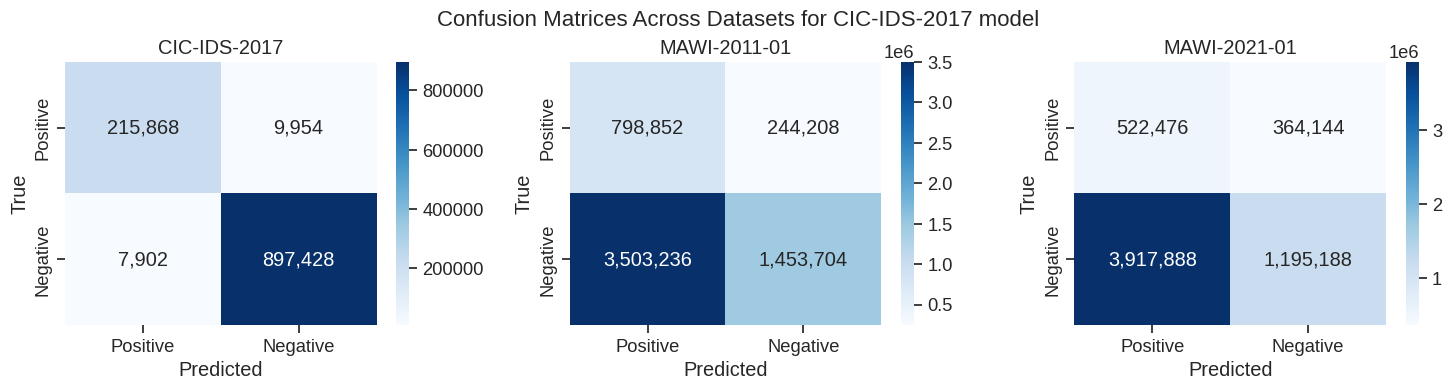

In [62]:
plot_confusion_matrices(
    [
        cic_ids_2017_report,
        cic_ids_2017_on_mawi_2011_01_report_labels,
        cic_ids_2017_on_mawi_2021_01_report_labels
    ],
    ["CIC-IDS-2017", "MAWI-2011-01", "MAWI-2021-01"],
    "Confusion Matrices Across Datasets for CIC-IDS-2017 model"
)

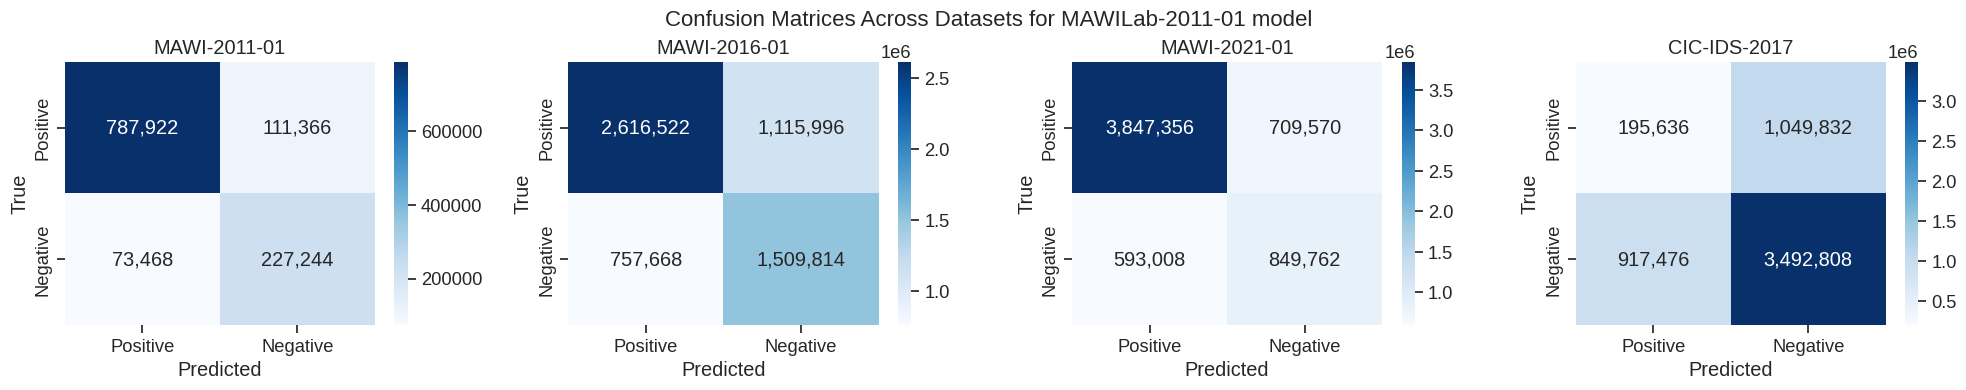

In [63]:
plot_confusion_matrices(
    [
        mawi_2011_01_report_labels,
        mawi_2011_01_on_mawi_2016_01_report_labels,
        mawi_2011_01_on_mawi_2021_01_report_labels,
        mawi_2011_01_on_cic_ids_2017_report
    ],
    ["MAWI-2011-01", "MAWI-2016-01", "MAWI-2021-01", "CIC-IDS-2017"],
    "Confusion Matrices Across Datasets for MAWILab-2011-01 model"
)

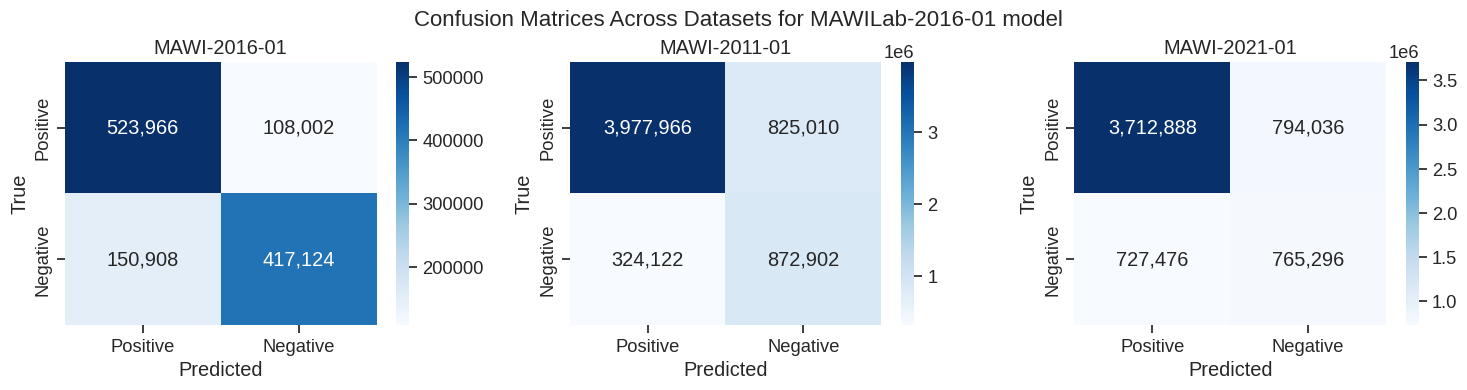

In [64]:
plot_confusion_matrices(
    [
        mawi_2016_01_report_labels,
        mawi_2016_01_on_mawi_2011_01_report_labels,
        mawi_2016_01_on_mawi_2021_01_report_labels
    ],
    ["MAWI-2016-01", "MAWI-2011-01", "MAWI-2021-01"],
    "Confusion Matrices Across Datasets for MAWILab-2016-01 model"
)

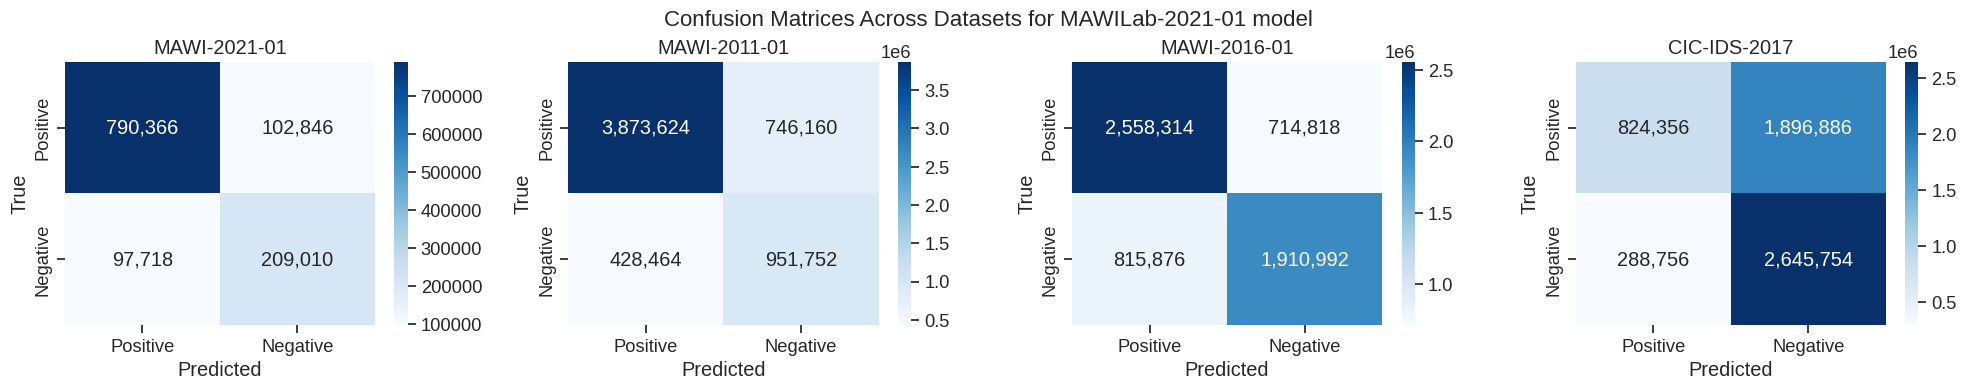

In [65]:
plot_confusion_matrices(
    [
        mawi_2021_01_report_labels,
        mawi_2021_01_on_mawi_2011_01_report_labels,
        mawi_2021_01_on_mawi_2016_01_report_labels,
        mawi_2021_01_on_cic_ids_2017_report
    ],
    ["MAWI-2021-01", "MAWI-2011-01", "MAWI-2016-01", "CIC-IDS-2017"],
    "Confusion Matrices Across Datasets for MAWILab-2021-01 model"
)

### ROC curves

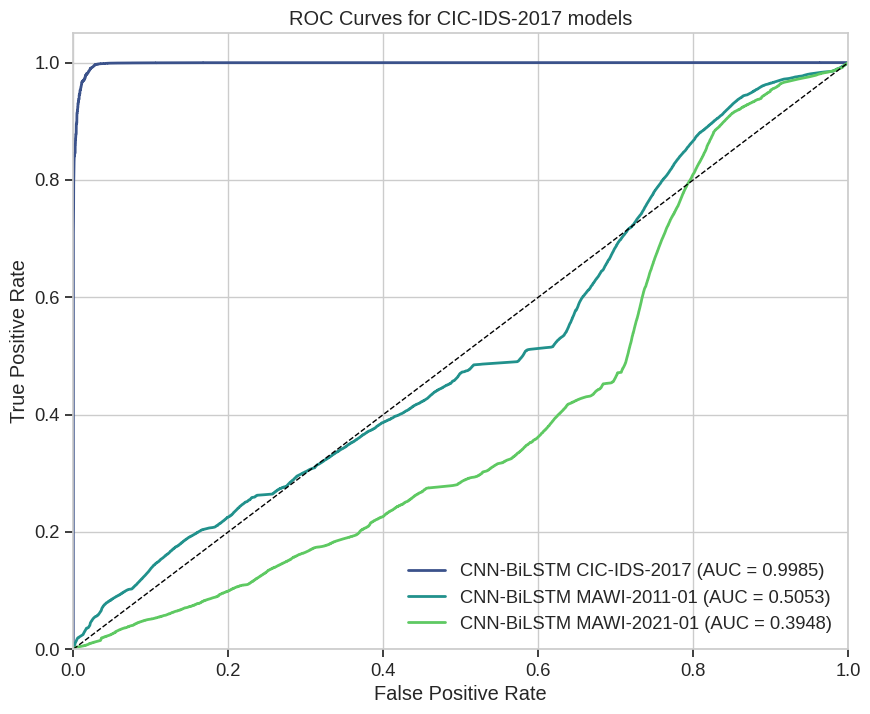

In [66]:
plot_roc_curves(
    [
        cic_ids_2017_pred,
        cic_ids_2017_on_mawi_2011_01_pred,
        cic_ids_2017_on_mawi_2021_01_pred
    ],
    [
        "CNN-BiLSTM CIC-IDS-2017",
        "CNN-BiLSTM MAWI-2011-01",
        "CNN-BiLSTM MAWI-2021-01"
    ],
    title="ROC Curves for CIC-IDS-2017 models",
    export_path="results/cic_ids_2017_roc_curves.pdf"
)

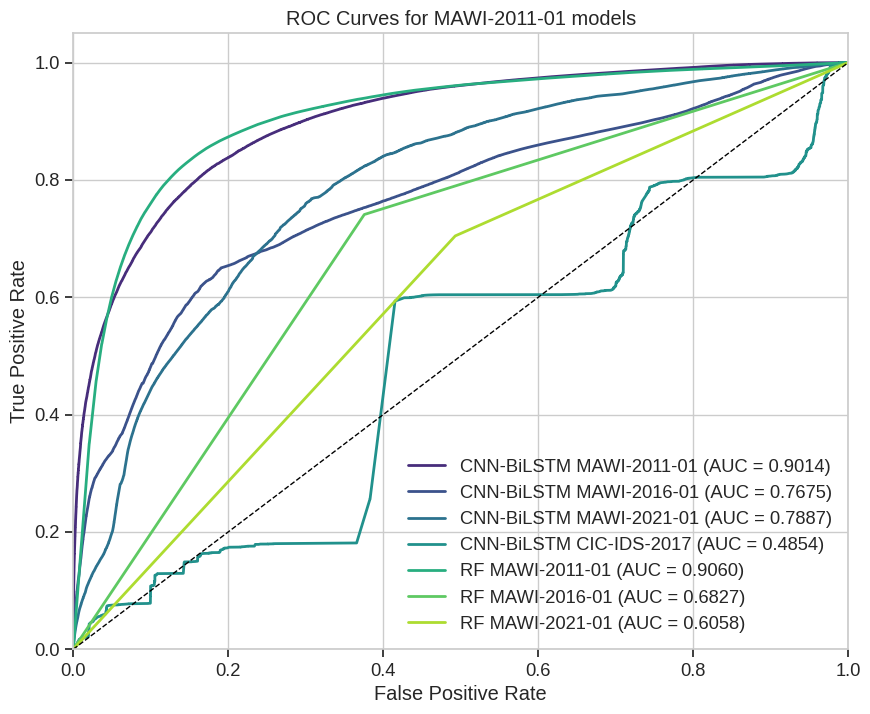

In [67]:
plot_roc_curves(
    [
        mawi_2011_01_pred,
        mawi_2011_01_on_mawi_2016_01_pred,
        mawi_2011_01_on_mawi_2021_01_pred,
        mawi_2011_01_on_cic_ids_2017_pred,
        mawi_2011_01_pred_rf,
        mawi_2011_01_on_mawi_2016_01_pred_rf,
        mawi_2011_01_on_mawi_2021_01_pred_rf
    ],
    [
        "CNN-BiLSTM MAWI-2011-01",
        "CNN-BiLSTM MAWI-2016-01",
        "CNN-BiLSTM MAWI-2021-01",
        "CNN-BiLSTM CIC-IDS-2017",
        "RF MAWI-2011-01",
        "RF MAWI-2016-01",
        "RF MAWI-2021-01"
    ],
    title="ROC Curves for MAWI-2011-01 models",
    export_path="results/roc_curves_mawi_2011_01.pdf"
)

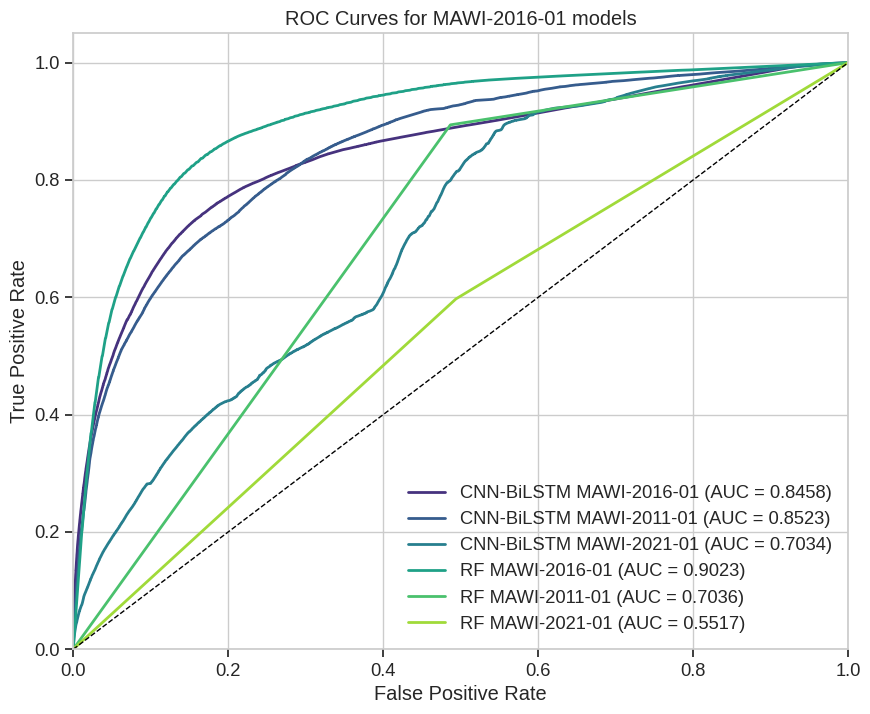

In [68]:
plot_roc_curves(
    [
        mawi_2016_01_pred,
        mawi_2016_01_on_mawi_2011_01_pred,
        mawi_2016_01_on_mawi_2021_01_pred,
        mawi_2016_01_pred_rf,
        mawi_2016_01_on_mawi_2011_01_pred_rf,
        mawi_2016_01_on_mawi_2021_01_pred_rf
    ],
    [
        "CNN-BiLSTM MAWI-2016-01",
        "CNN-BiLSTM MAWI-2011-01",
        "CNN-BiLSTM MAWI-2021-01",
        "RF MAWI-2016-01",
        "RF MAWI-2011-01",
        "RF MAWI-2021-01"
    ],
    title="ROC Curves for MAWI-2016-01 models",
    export_path="results/roc_curves_mawi_2016_01.pdf"
)

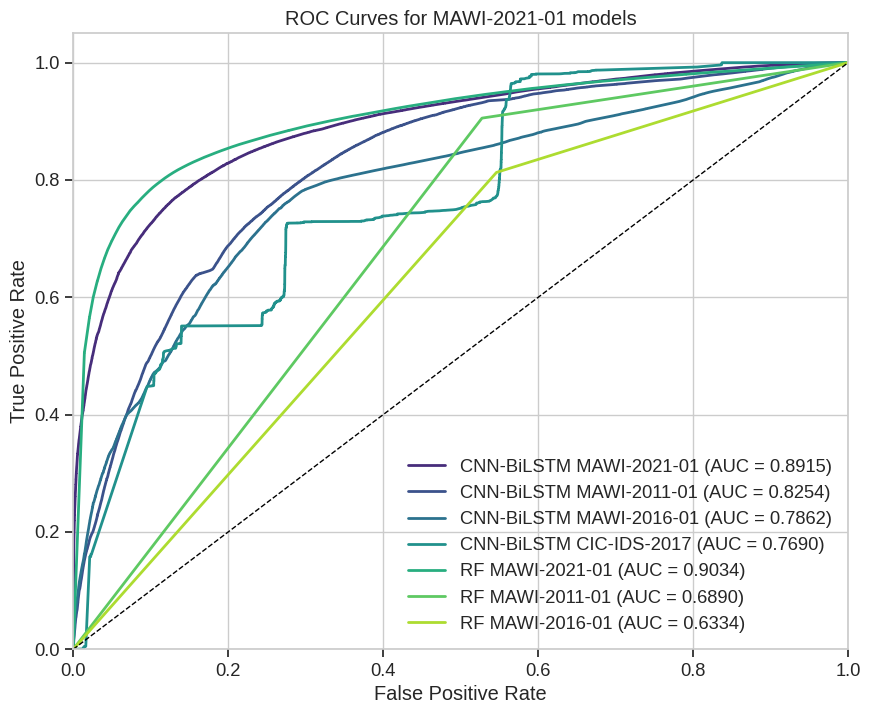

In [69]:
plot_roc_curves(
    [
        mawi_2021_01_pred,
        mawi_2021_01_on_mawi_2011_01_pred,
        mawi_2021_01_on_mawi_2016_01_pred,
        mawi_2021_01_on_cic_ids_2017_pred,
        mawi_2021_01_pred_rf,
        mawi_2021_01_on_mawi_2011_01_pred_rf,
        mawi_2021_01_on_mawi_2016_01_pred_rf,
    ],
    [
        "CNN-BiLSTM MAWI-2021-01",
        "CNN-BiLSTM MAWI-2011-01",
        "CNN-BiLSTM MAWI-2016-01",
        "CNN-BiLSTM CIC-IDS-2017",
        "RF MAWI-2021-01",
        "RF MAWI-2011-01",
        "RF MAWI-2016-01"
    ],
    title="ROC Curves for MAWI-2021-01 models",
    export_path="results/roc_curves_mawi_2021_01.pdf"
)

## Predicting MAWILab-2021-02

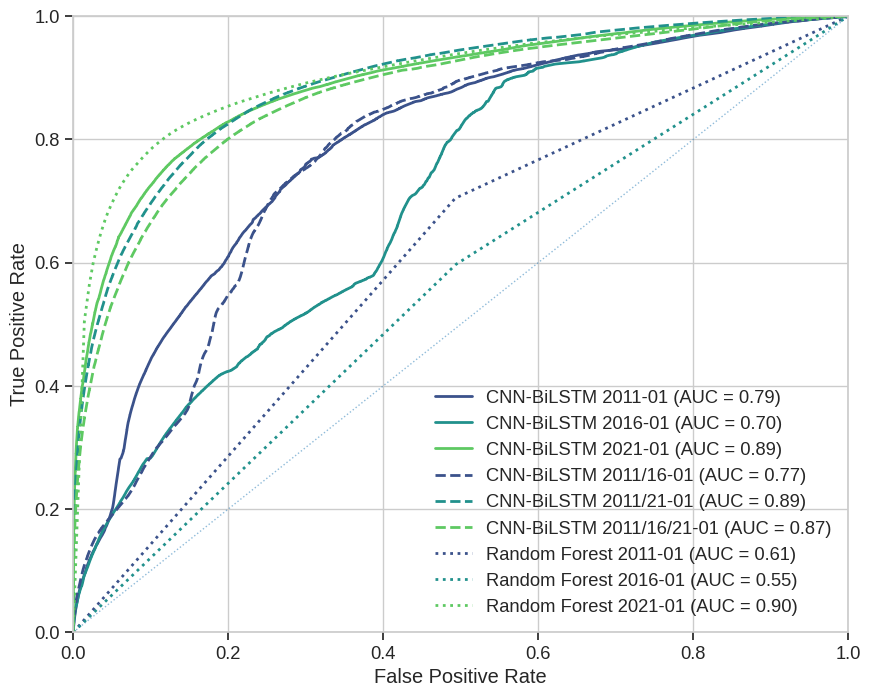

In [77]:
colors = sns.color_palette("viridis", 3)

datasets = [
    {
        'data': mawi_2011_01_on_mawi_2021_01_pred,
        'label':"CNN-BiLSTM 2011-01",
        'color': colors[0],
        'linestyle': 'solid'
    },
    {
        'data': mawi_2016_01_on_mawi_2021_01_pred,
        'label':"CNN-BiLSTM 2016-01",
        'color': colors[1],
        'linestyle': 'solid'
    },
    {
        'data': mawi_2021_01_pred,
        'label':"CNN-BiLSTM 2021-01",
        'color': colors[2],
        'linestyle': 'solid'
    },
    {
        'data': mawi_2011_01_2016_01_on_mawi_2021_01_pred,
        'label':"CNN-BiLSTM 2011/16-01",
        'color': colors[0],
        'linestyle': 'dashed'
    },
    {
        'data': mawi_2011_01_2021_01_pred,
        'label':"CNN-BiLSTM 2011/21-01",
        'color': colors[1],
        'linestyle': 'dashed'
    },
    {
        'data': mawi_2011_01_2016_01_2021_01_pred,
        'label':"CNN-BiLSTM 2011/16/21-01",
        'color': colors[2],
        'linestyle': 'dashed'
    },
    {
        'data': mawi_2011_01_on_mawi_2021_01_pred_rf,
        'label':"Random Forest 2011-01",
        'color': colors[0],
        'linestyle': 'dotted'
    },
    {
        'data': mawi_2016_01_on_mawi_2021_01_pred_rf,
        'label':"Random Forest 2016-01",
        'color': colors[1],
        'linestyle': 'dotted'
    },
    {
        'data': mawi_2021_01_pred_rf,
        'label':"Random Forest 2021-01",
        'color': colors[2],
        'linestyle': 'dotted'
    },
]


plt.figure(figsize=(10, 8))

for dataset in datasets:
    y_true = dataset['data']['y'].to_numpy()
    y_score = dataset['data']['y_pred_proba'].to_numpy()

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr, tpr,
        lw=2,
        color=dataset['color'],
        linestyle=dataset['linestyle'],
        label=f'{dataset['label']} (AUC = {roc_auc:.2f})',
    )

# Add reference line and formatting
plt.plot([0, 1], [0, 1], linestyle='dotted', lw=1, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

plt.savefig("results/roc_curves_for_mawilab_v1.1_2021_01.pdf",
            format="pdf",
            bbox_inches="tight",
            pad_inches=0.1)

plt.show()

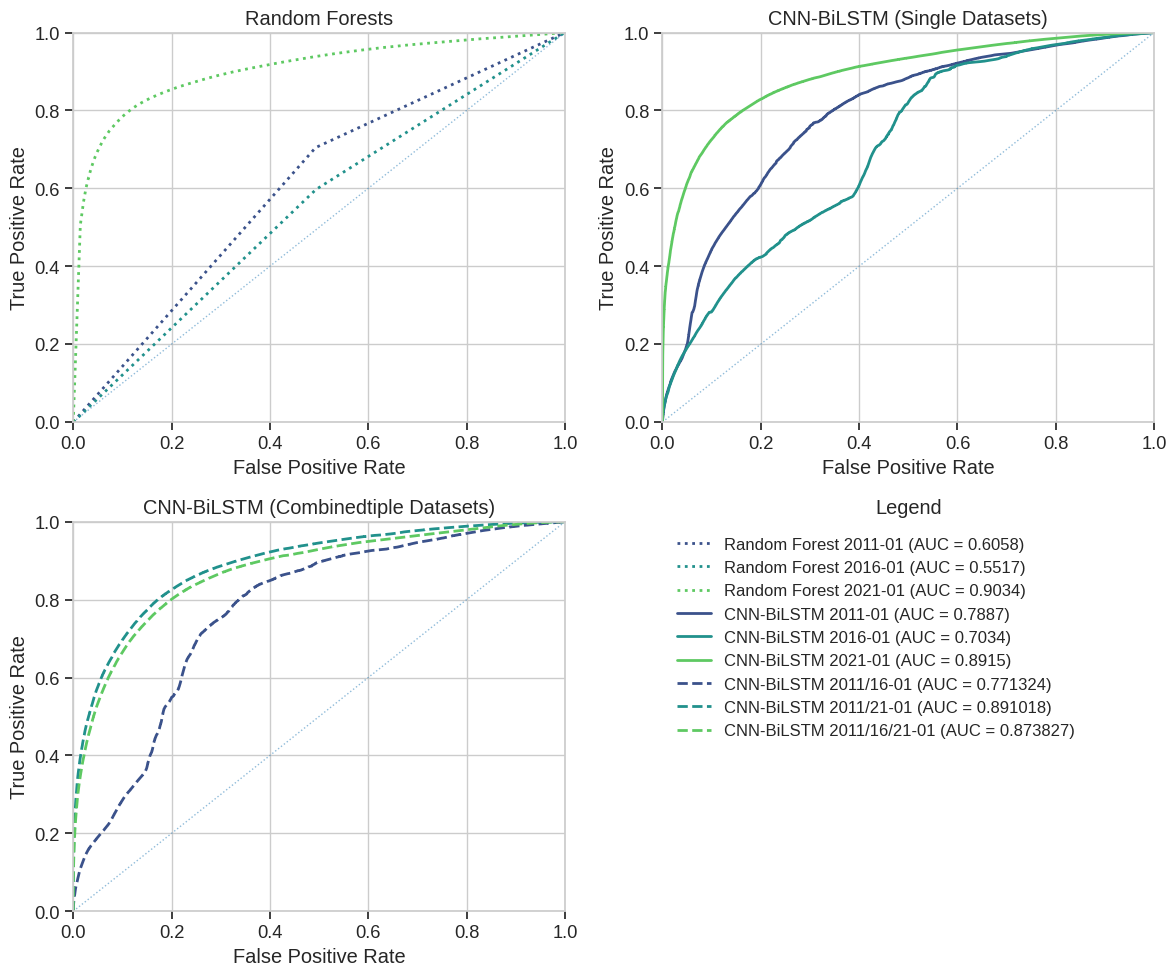

In [78]:
# Create a 2×2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Upper-left: Random Forests only (datasets[6], [7], [8])
for ds in datasets[6:9]:
    y_true = ds['data']['y'].to_numpy()
    y_score = ds['data']['y_pred_proba'].to_numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    axs[0, 0].plot(
        fpr, tpr,
        color=ds['color'],
        linestyle=ds['linestyle'],
        lw=2,
        label=f"{ds['label']} (AUC = {roc_auc:.4f})"
    )
# Diagonal reference line
axs[0, 0].plot([0, 1], [0, 1], linestyle='dotted', lw=1, alpha=0.5)
axs[0, 0].set_title("Random Forests")
axs[0, 0].set_xlabel("False Positive Rate")
axs[0, 0].set_ylabel("True Positive Rate")
axs[0, 0].set_xlim([0.0, 1.0])
axs[0, 0].set_ylim([0.0, 1.0])
axs[0, 0].grid(True)

# Upper-right: CNN-BiLSTM (single datasets only: datasets[0], [1], [2])
for ds in datasets[0:3]:
    y_true = ds['data']['y'].to_numpy()
    y_score = ds['data']['y_pred_proba'].to_numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    axs[0, 1].plot(
        fpr, tpr,
        color=ds['color'],
        linestyle=ds['linestyle'],
        lw=2,
        label=f"{ds['label']} (AUC = {roc_auc:.4f})"
    )
axs[0, 1].plot([0, 1], [0, 1], linestyle='dotted', lw=1, alpha=0.5)
axs[0, 1].set_title("CNN-BiLSTM (Single Datasets)")
axs[0, 1].set_xlabel("False Positive Rate")
axs[0, 1].set_ylabel("True Positive Rate")
axs[0, 1].set_xlim([0.0, 1.0])
axs[0, 1].set_ylim([0.0, 1.0])
axs[0, 1].grid(True)

# Lower-left: CNN-BiLSTM (multiple datasets only: datasets[3], [4], [5])
for ds in datasets[3:6]:
    y_true = ds['data']['y'].to_numpy()
    y_score = ds['data']['y_pred_proba'].to_numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    axs[1, 0].plot(
        fpr, tpr,
        color=ds['color'],
        linestyle=ds['linestyle'],
        lw=2,
        label=f"{ds['label']} (AUC = {roc_auc:4f})"
    )
axs[1, 0].plot([0, 1], [0, 1], linestyle='dotted', lw=1, alpha=0.5)
axs[1, 0].set_title("CNN-BiLSTM (Combinedtiple Datasets)")
axs[1, 0].set_xlabel("False Positive Rate")
axs[1, 0].set_ylabel("True Positive Rate")
axs[1, 0].set_xlim([0.0, 1.0])
axs[1, 0].set_ylim([0.0, 1.0])
axs[1, 0].grid(True)

# Lower-right: Legend only, placed in upper-left of that subplot
axs[1, 1].axis('off')  # Hide plot axes
handles, labels = [], []
for ax in (axs[0, 0], axs[0, 1], axs[1, 0]):
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
axs[1, 1].legend(
    handles, labels,
    loc='upper left',
    fontsize='small'
)
axs[1, 1].set_title("Legend")

plt.tight_layout()

plt.savefig("results/roc_curves_for_mawilab_v1.1_2021_01_2x2.pdf",
            format="pdf",
            bbox_inches="tight",
            pad_inches=0.1)
plt.show()

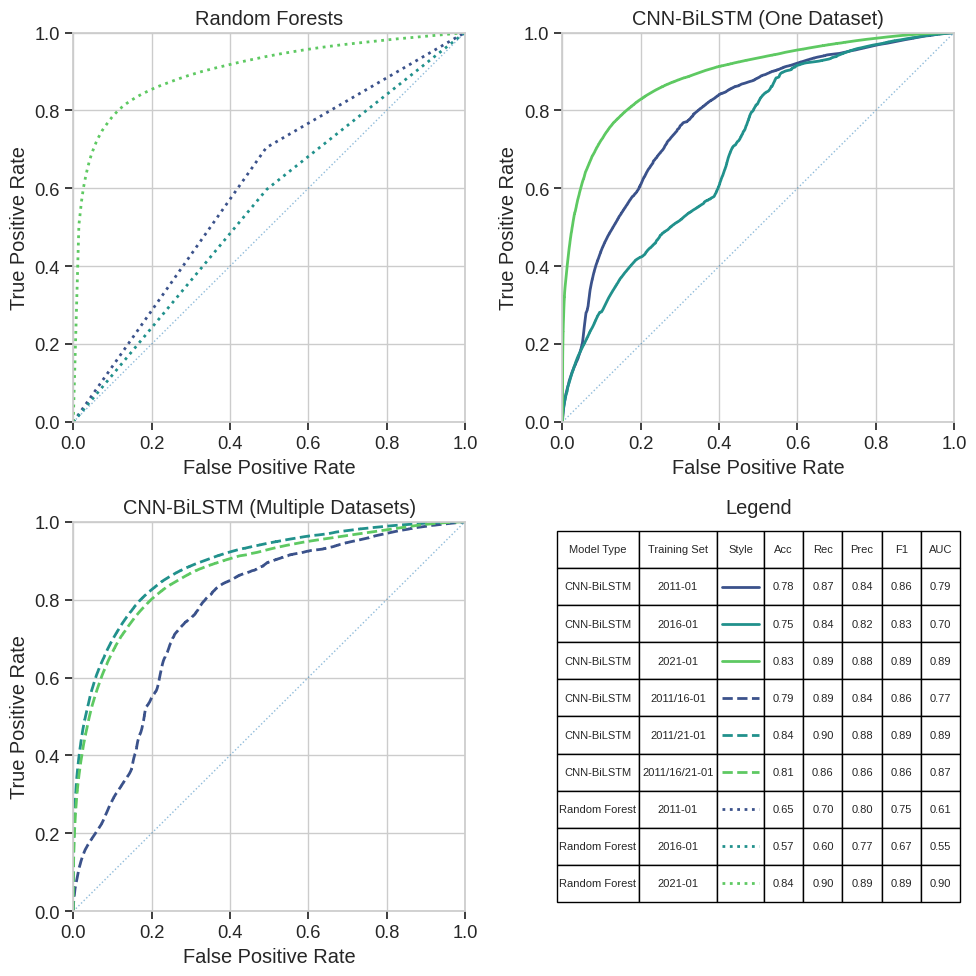

In [79]:
table_entries = []
for ds in datasets:
    label = ds['label']
    if label.startswith("CNN-BiLSTM"):
        model_type = "CNN-BiLSTM"
        training_set = label.replace("CNN-BiLSTM ", "")
    else:
        model_type = "Random Forest"
        training_set = label.replace("Random Forest ", "")

    y_true = ds['data']['y'].to_numpy()
    y_score = ds['data']['y_pred_proba'].to_numpy()

    # Predicted labels at threshold = 0.5
    y_pred = (y_score >= 0.5).astype(int)

    # Compute Accuracy, Recall, Precision, F1
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # ROC & AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Hex string for the color
    hex_color = mcolors.to_hex(ds['color'])

    table_entries.append({
        'model_type': model_type,
        'training_set': training_set,
        'color_hex': hex_color,
        'linestyle': ds['linestyle'],
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'auc': roc_auc
    })

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# ----- (0,0): Random Forests only (indices 6,7,8) -----
for ds in datasets[6:9]:
    y_true = ds['data']['y'].to_numpy()
    y_score = ds['data']['y_pred_proba'].to_numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    axs[0, 0].plot(
        fpr, tpr,
        color=ds['color'],
        linestyle=ds['linestyle'],
        lw=2,
        label=f"{ds['label']} (AUC={roc_auc:.2f})"
    )

axs[0, 0].plot([0, 1], [0, 1], linestyle='dotted', lw=1, alpha=0.5)
axs[0, 0].set_title("Random Forests")
axs[0, 0].set_xlabel("False Positive Rate")
axs[0, 0].set_ylabel("True Positive Rate")
axs[0, 0].set_xlim([0, 1])
axs[0, 0].set_ylim([0, 1])
axs[0, 0].grid(True)

# ----- (0,1): CNN‐BiLSTM on one dataset (indices 0,1,2) -----
for ds in datasets[0:3]:
    y_true = ds['data']['y'].to_numpy()
    y_score = ds['data']['y_pred_proba'].to_numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    axs[0, 1].plot(
        fpr, tpr,
        color=ds['color'],
        linestyle=ds['linestyle'],
        lw=2,
        label=f"{ds['label']} (AUC={roc_auc:.2f})"
    )

axs[0, 1].plot([0, 1], [0, 1], linestyle='dotted', lw=1, alpha=0.5)
axs[0, 1].set_title("CNN-BiLSTM (One Dataset)")
axs[0, 1].set_xlabel("False Positive Rate")
axs[0, 1].set_ylabel("True Positive Rate")
axs[0, 1].set_xlim([0, 1])
axs[0, 1].set_ylim([0, 1])
axs[0, 1].grid(True)

# ----- (1,0): CNN‐BiLSTM on multiple datasets (indices 3,4,5) -----
for ds in datasets[3:6]:
    y_true = ds['data']['y'].to_numpy()
    y_score = ds['data']['y_pred_proba'].to_numpy()
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    axs[1, 0].plot(
        fpr, tpr,
        color=ds['color'],
        linestyle=ds['linestyle'],
        lw=2,
        label=f"{ds['label']} (AUC={roc_auc:.2f})"
    )

axs[1, 0].plot([0, 1], [0, 1], linestyle='dotted', lw=1, alpha=0.5)
axs[1, 0].set_title("CNN-BiLSTM (Multiple Datasets)")
axs[1, 0].set_xlabel("False Positive Rate")
axs[1, 0].set_ylabel("True Positive Rate")
axs[1, 0].set_xlim([0, 1])
axs[1, 0].set_ylim([0, 1])
axs[1, 0].grid(True)

# ----- (1,1): Table of metrics + rendered “Style” lines -----
axs[1, 1].axis('off')  # Hide axes—only table appears

table_data = []
for entry in table_entries:
    table_data.append([
        entry['model_type'],
        entry['training_set'],
        "",  # placeholder for style‐sample
        f"{entry['accuracy']:.2f}",
        f"{entry['recall']:.2f}",
        f"{entry['precision']:.2f}",
        f"{entry['f1']:.2f}",
        f"{entry['auc']:.2f}"
    ])

col_labels = ["Model Type", "Training Set", "Style", "Acc", "Rec", "Prec", "F1", "AUC"]

# Specify column widths to alleviate overlap
col_widths = [0.21, 0.20, 0.12, 0.10, 0.10, 0.10, 0.10, 0.10]

table = axs[1, 1].table(
    cellText=table_data,
    colLabels=col_labels,
    cellLoc='center',
    loc='center',
    colWidths=col_widths
)

# Adjust font & scale
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 2)

# Draw each line sample inside its “Style” cell:
fig.canvas.draw()  # Populate renderer
renderer = fig.canvas.get_renderer()

style_col_idx = 2  # “Style” is now column index 2
for row_idx, entry in enumerate(table_entries):
    cell = table[row_idx + 1, style_col_idx]  # +1 for header row
    bbox = cell.get_window_extent(renderer)
    inv = axs[1, 1].transData.inverted()
    (x0, y0), (x1, y1) = inv.transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
    y_center = (y0 + y1) / 2
    margin = (x1 - x0) * 0.1

    axs[1, 1].add_line(Line2D(
        [x0 + margin, x1 - margin],
        [y_center, y_center],
        color=entry['color_hex'],
        linestyle=entry['linestyle'],
        linewidth=2
    ))

axs[1, 1].set_title("Legend")

plt.tight_layout()

plt.savefig("results/roc_curves_for_mawilab_v1.1_2021_01_2x2_table.pdf",
            format="pdf",
            bbox_inches="tight",
            pad_inches=0.1)

plt.show()